# Experiments for NIPS 2016
---

* Inspect JA, EE trajectories for Clothing Assistance Tasks
* Inspect latent trajectories from BGPLVM Models
* Fit DMP to Joint Angle trajectories and Latent Space trajectories
* Extract via-points from desired Joint Angle trajectory
* Design cost function to learn desired Joint Angle trajectory
* Implement CEM reinforcement learning
* Apply CEM RL to both JA and latent space models
* Compile results of applying RL

## Environment Setup
---

In [1]:
# import the modules
import os
import sys
import GPy
import csv
import time
import pydmps
import random
import argparse
import matplotlib
import numpy as np
from os import listdir
import cPickle as pickle
from matplotlib import cm
from tabulate import tabulate
from os.path import isfile, join
from sklearn import preprocessing
from itertools import combinations
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from GPy.plotting.matplot_dep.controllers.imshow_controller import ImshowController
from GPy.inference.latent_function_inference import InferenceMethodList, VarDTC, VarDTC_minibatch

%matplotlib notebook

In [2]:
# load the processed dataset
data = pickle.load(open('Data/Data.p','r'))

# load the ja and ee models
jaModels = pickle.load(open('Results/JAModels.p','r'))
eeModels = pickle.load(open('Results/EEModels.p','r'))

# load the experimental results
jaOutputs = pickle.load(open('Results/JAResults.p','rb'))
eeOutputs = pickle.load(open('Results/EEResults.p','rb'))

## Data Inspection
---

In [7]:
LEFT_ANGLE_OFFSET = 1
RIGHT_ANGLE_OFFSET = 8

def plotTraj(Dataset, plotType = 0, jointIndex = np.arange(7), labels = ['Train','Test'], colors=['b','r']):
    """function to plot multiple joint tracks."""
    timeData = []
    leftData = []
    rightData = []

    # loop over first plotNum files
    for data in Dataset.values():
        timeData.append(data[:, 0])
        leftData.append(data[:, LEFT_ANGLE_OFFSET+jointIndex])
        rightData.append(data[:, RIGHT_ANGLE_OFFSET+jointIndex])

    jointData = [leftData, rightData]

    # number of joints to plot
    xlabel = 'Time(sec)'
    arms = ['Left', 'Right']
    nJoints = jointIndex.size
    if plotType == 0:
        ylabels = 7*['Joint Angle (rad)']
    else:
        ylabels = 3*['Position (m)']+4*['Angle (rad)']

    # plot all the joint data
    for ind in range(2):
        fig = plt.figure(figsize=(10, 2*nJoints))
        for i, jI in enumerate(jointIndex):
            plt.subplot(nJoints, 1, i+1)

            # plot all the tracks
            for n in range(len(Dataset.values())):
                timeDat = timeData[n]
                nSamples = jointData[ind][n].shape[0]
                plt.plot(timeDat, jointData[ind][n][:, i], label=labels[n], color=colors[n], linewidth=2)

            plt.xlabel(xlabel, fontsize=12, fontweight='bold')
            plt.ylabel(ylabels[i], fontsize=12, fontweight='bold')

            if plotType == 0:
                plt.title('%s Joint %d' % (arms[ind], jI+1), fontsize=15, fontweight='bold')
            else:
                plt.title('%s Pose %d' % (arms[ind], jI+1), fontsize=15, fontweight='bold')

            # plot legend only for 1st sub plot
            if i == 0:
                plt.legend()

        # adjust subplots for legend
        fig.subplots_adjust(top=0.96, right=0.8)
        plt.tight_layout()

    # show all the plots
    plt.show()

<IPython.core.display.Javascript object>


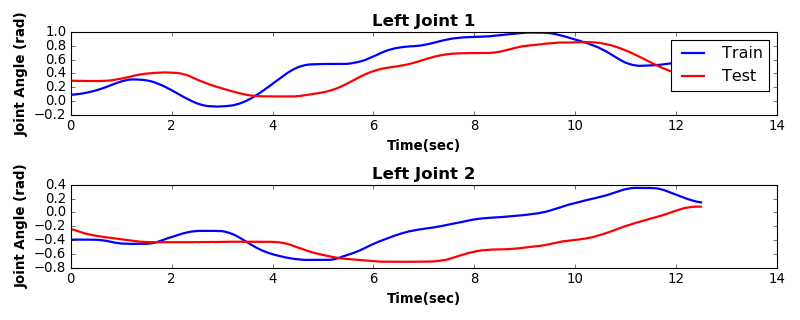

<IPython.core.display.Javascript object>


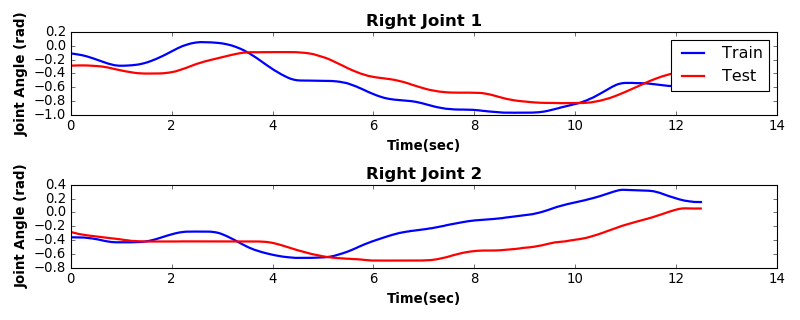

<IPython.core.display.Javascript object>


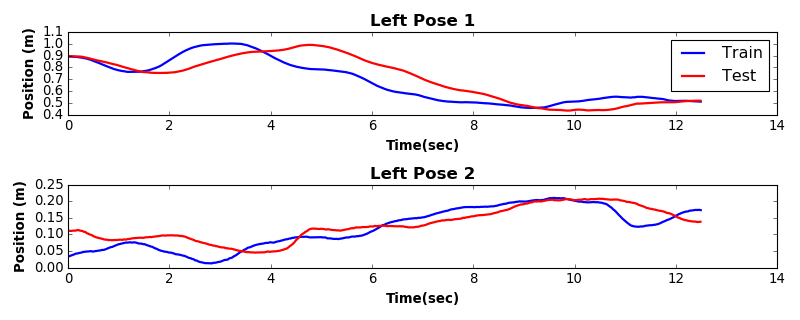

<IPython.core.display.Javascript object>


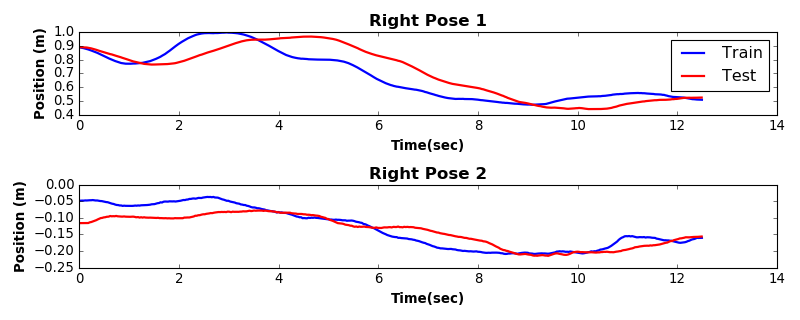

In [8]:
# set the train and test data trials
nPoints = 400
datasets = {}
keys = ['JA','EE']
for ind, key in enumerate(keys):
    trData = data[key]['65']
    tsData = data[key]['75']
    
    nTr = trData.shape[0]
    nTs = tsData.shape[0]
    
    trData = trData[np.linspace(0,nTr,num=nPoints,endpoint=False,dtype=np.int)]
    tsData = tsData[np.linspace(0,nTs,num=nPoints,endpoint=False,dtype=np.int)]
    
    datasets[key] = {'Train':trData, 'Test':tsData}
    plotTraj(datasets[key], plotType=ind, jointIndex=np.asarray([0,1]))

## Latent Data Inspection
---

In [10]:
def plotLatent(model, trainInput, testInput, nPoints=400, wThresh=0.05):
    sTest = 200
    sTrain = 150
    resolution = 50

    testMarker = 's'
    trainMarker = 'o'
    
    testLabels = [(1,0,0)]*nPoints
    trainLabels = [(0,0,1)]*nPoints
    
    # get active dimensions
    scales = model.kern.input_sensitivity(summarize=False)
    scales = scales/scales.max()
    activeDims = np.where(scales > wThresh)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # get latent space plot parameters
    plotIndices = [0,1]
    qDim = model.X.mean.shape[1]
    input1, input2 = plotIndices
        
    # loop over test data
    saveDim = activeDims[0].shape[0]
    testData = np.zeros((testInput.shape[0], saveDim))
    trainData = np.zeros((trainInput.shape[0], saveDim))
    
    for n in range(trainInput.shape[0]):
        # infer latent position
        xTrain, _ = model.infer_newX(np.atleast_2d(trainInput[n,:]), optimize=True)
        
        # update parameter
        trainData[n,:] = xTrain.mean[0,activeDims[0]]
        sys.stdout.write('.') 
    sys.stdout.write('\n')
    
    for n in range(testInput.shape[0]):
        # infer latent position
        xTest, _ = model.infer_newX(np.atleast_2d(testInput[n,:]), optimize=True)
        
        # update parameter
        testData[n,:] = xTest.mean[0,activeDims[0]]
        sys.stdout.write('.') 
    sys.stdout.write('\n')       

    # compute plot limits
    xmin, ymin = trainData[:, [input1, input2]].min(0)
    xmax, ymax = trainData[:, [input1, input2]].max(0)
    x_r, y_r = xmax-xmin, ymax-ymin
    xmin -= .1*x_r
    xmax += .1*x_r
    ymin -= .1*y_r
    ymax += .1*y_r

    # plot the variance for the model
    def plotFunction(x):
        Xtest_full = np.zeros((x.shape[0], qDim))
        Xtest_full[:, [input1, input2]] = x
        _, var = model.predict(np.atleast_2d(Xtest_full))
        var = var[:, :1]
        return -np.log(var)

    x, y = np.mgrid[xmin:xmax:1j*resolution, ymin:ymax:1j*resolution]
    gridData = np.hstack((x.flatten()[:, None], y.flatten()[:, None]))
    gridVariance = (plotFunction(gridData)).reshape((resolution, resolution))

    varianceHandle = plt.imshow(gridVariance.T, interpolation='bilinear', origin='lower', cmap=cm.gray,
                                extent=(xmin, xmax, ymin, ymax))

    # test and training plotting
    testHandle = ax.scatter(testData[:, input1], testData[:, input2], marker=testMarker, s=sTest, c=testLabels, 
                            linewidth=.2, edgecolor='k', alpha=1.)
    trainHandle = ax.scatter(trainData[:, input1], trainData[:, input2], marker=trainMarker, s=sTrain, c=trainLabels, 
                            linewidth=.2, edgecolor='k', alpha=1.)

    ax.grid(b=False)
    ax.set_aspect('auto')
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlabel('Latent Dimension %i' % (input1+1), fontsize=25, fontweight='bold')
    ax.set_ylabel('Latent Dimension %i' % (input2+1), fontsize=25, fontweight='bold')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    properties = {'weight':'bold','size':25}
    plt.legend([trainHandle, testHandle], ['Train', 'Test'], prop=properties)
    
    fig.canvas.draw()
    fig.tight_layout()
    fig.canvas.draw()
    plt.show()

    return trainData, testData

In [11]:
def plotLatentTraj(Dataset, labels = ['Train','Test'], colors=['b','r']):
    """function to plot multiple joint tracks."""
    timeData = {}
    latentData = {}
    # loop over first plotNum files
    for key,data in enumerate(Dataset):
        timeData[key] = data[:, 0]
        latentData[key] = data[:, 1:]
    
    # number of latent dims to plot
    xlabel = 'Time(sec)'
    nDim = latentData['Train'].shape[1]
    ylabels = nDim*['Latent Position']

    # plot all the latent data
    fig = plt.figure(figsize=(10, 2*nDim))
    for i, jI in enumerate(range(nDim)):
        plt.subplot(nDim, 1, i+1)

        # plot all the tracks
        for key in Dataset.keys():
            timeDat = timeData[key]
            nSamples = latentData[key].shape[0]
            plt.plot(timeDat, latentData[key][:, i], label=labels[n], color=colors[n], linewidth=2)

        plt.xlabel(xlabel, fontsize=12, fontweight='bold')
        plt.ylabel(ylabels[i], fontsize=12, fontweight='bold')
        plt.title('Latent Dim %d' % (jI+1), fontsize=15, fontweight='bold')

        # plot legend only for 1st sub plot
        if i == 0:
            plt.legend()

    # adjust subplots for legend
    fig.subplots_adjust(top=0.96, right=0.8)
    plt.tight_layout()

    # show all the plots
    plt.show()

<IPython.core.display.Javascript object>


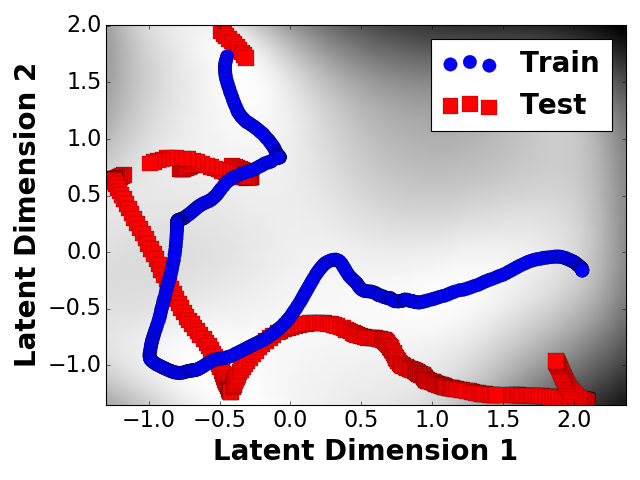

................................................................................................................................................................................................................................................................................................................................................................................................................
................................................................................................................................................................................................................................................................................................................................................................................................................


<IPython.core.display.Javascript object>


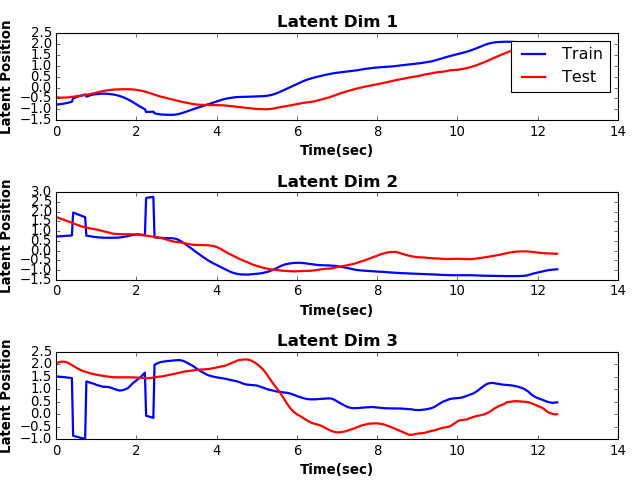

<IPython.core.display.Javascript object>


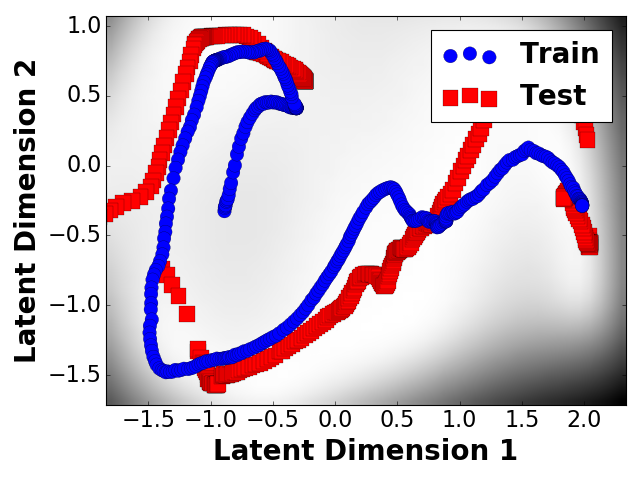

................................................................................................................................................................................................................................................................................................................................................................................................................
................................................................................................................................................................................................................................................................................................................................................................................................................


<IPython.core.display.Javascript object>


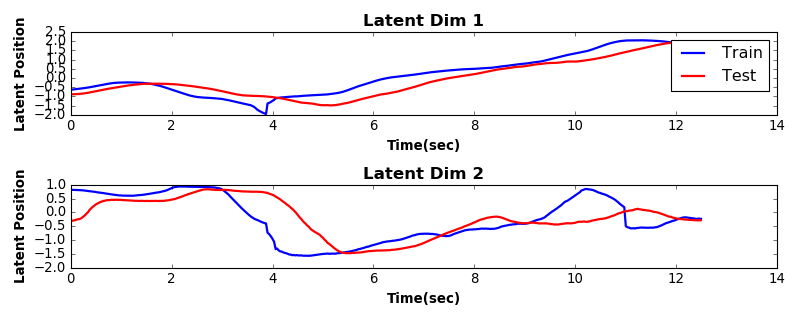

In [16]:
latentsets = {}
models = {'JA':jaModels['BGPLVM'],'EE':eeModels['BGPLVM']}

for key in keys:
    (trLatent, tsLatent) = plotLatent(models[key], datasets[key]['Train'][:,1:], datasets[key]['Test'][:,1:])
    trLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Train'][:,0])),trLatent),axis=1)
    tsLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Test'][:,0])),tsLatent),axis=1)
    
    # append to dataset dict
    latentsets[key] = {'Train':trLatent,'Test':tsLatent}
    
    # plot latent trajectories
    plotLatentTraj(latentsets[key])

## DMP on Trajectories
---

In [ ]:
# use pydmps library by Travis DeWolf
